In [5]:
from __future__ import absolute_import, division, print_function
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.filters import threshold_otsu
import numpy as np
import pandas as pd
from glob import glob
import scipy.misc
import tensorflow as tf
from matplotlib.patches import Circle,Ellipse
from matplotlib.patches import Rectangle
import os
from PIL import Image, ImageFilter
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
import skimage
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import BatchNormalization
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
#https://www.geeksforgeeks.org/os-walk-python/
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
dataset_dir = 'fingerprintdataset2'
for dirname, dirnames, filenames in os.walk(dataset_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

fingerprintdataset2/fingerprints/DB1_B/108_4.tif
fingerprintdataset2/fingerprints/DB1_B/105_1.tif
fingerprintdataset2/fingerprints/DB1_B/110_1.tif
fingerprintdataset2/fingerprints/DB1_B/108_2.tif
fingerprintdataset2/fingerprints/DB1_B/102_4.tif
fingerprintdataset2/fingerprints/DB1_B/102_5.tif
fingerprintdataset2/fingerprints/DB1_B/109_3.tif
fingerprintdataset2/fingerprints/DB1_B/108_5.tif
fingerprintdataset2/fingerprints/DB1_B/110_7.tif
fingerprintdataset2/fingerprints/DB1_B/107_4.tif
fingerprintdataset2/fingerprints/DB1_B/108_7.tif
fingerprintdataset2/fingerprints/DB1_B/102_1.tif
fingerprintdataset2/fingerprints/DB1_B/104_8.tif
fingerprintdataset2/fingerprints/DB1_B/106_5.tif
fingerprintdataset2/fingerprints/DB1_B/110_5.tif
fingerprintdataset2/fingerprints/DB1_B/110_6.tif
fingerprintdataset2/fingerprints/DB1_B/106_8.tif
fingerprintdataset2/fingerprints/DB1_B/105_6.tif
fingerprintdataset2/fingerprints/DB1_B/101_7.tif
fingerprintdataset2/fingerprints/DB1_B/108_8.tif
fingerprintdataset2/

In [6]:
import imageio
#https://docs.python.org/3/library/glob.html
data = glob('fingerprintdataset2/fingerprints/DB*/*')
images = []
from matplotlib.pyplot import imread
def readImages(data):
    for i in range(len(data)):
        #loads image from the files 
        #https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/
        img = cv2.imread(data[i],0)
        #resizes them to 224 by 224
        img = cv2.resize(img,(224,224))
        images.append(img)
        
    return images
#returns new list of resized images
images = readImages(data)

Display random images from dataset


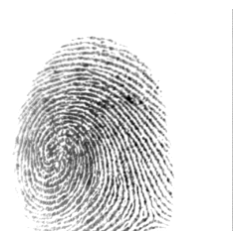

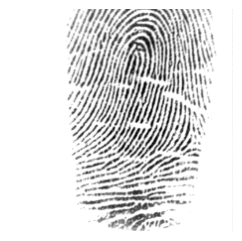

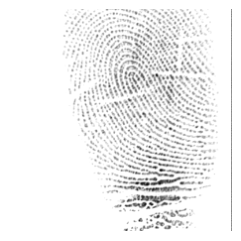

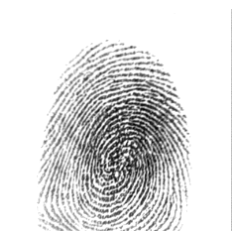

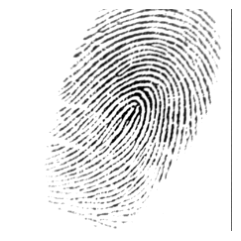

In [7]:
def plot_images(images):
    print("Display random images from dataset")
    for i in range(5):
        #https://matplotlib.org/stable/api/
        #create a 12 pixel by 12 pixel window
        plt.figure(figsize = (12,12))
                #specifies where to put the image
        plt.subplot(5, 5, i+1)
        plt.set_cmap('gray')
        plt.imshow(images[i])
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
plot_images(images)

/tmp/ipykernel_117423/3273384756.py:2: FutureWarning: use_gaussian_derivatives currently defaults to False, but will change to True in a future version. Please specify this argument explicitly to maintain the current behavior
  H_elems = hessian_matrix(gray, sigma=sigma, order='rc')


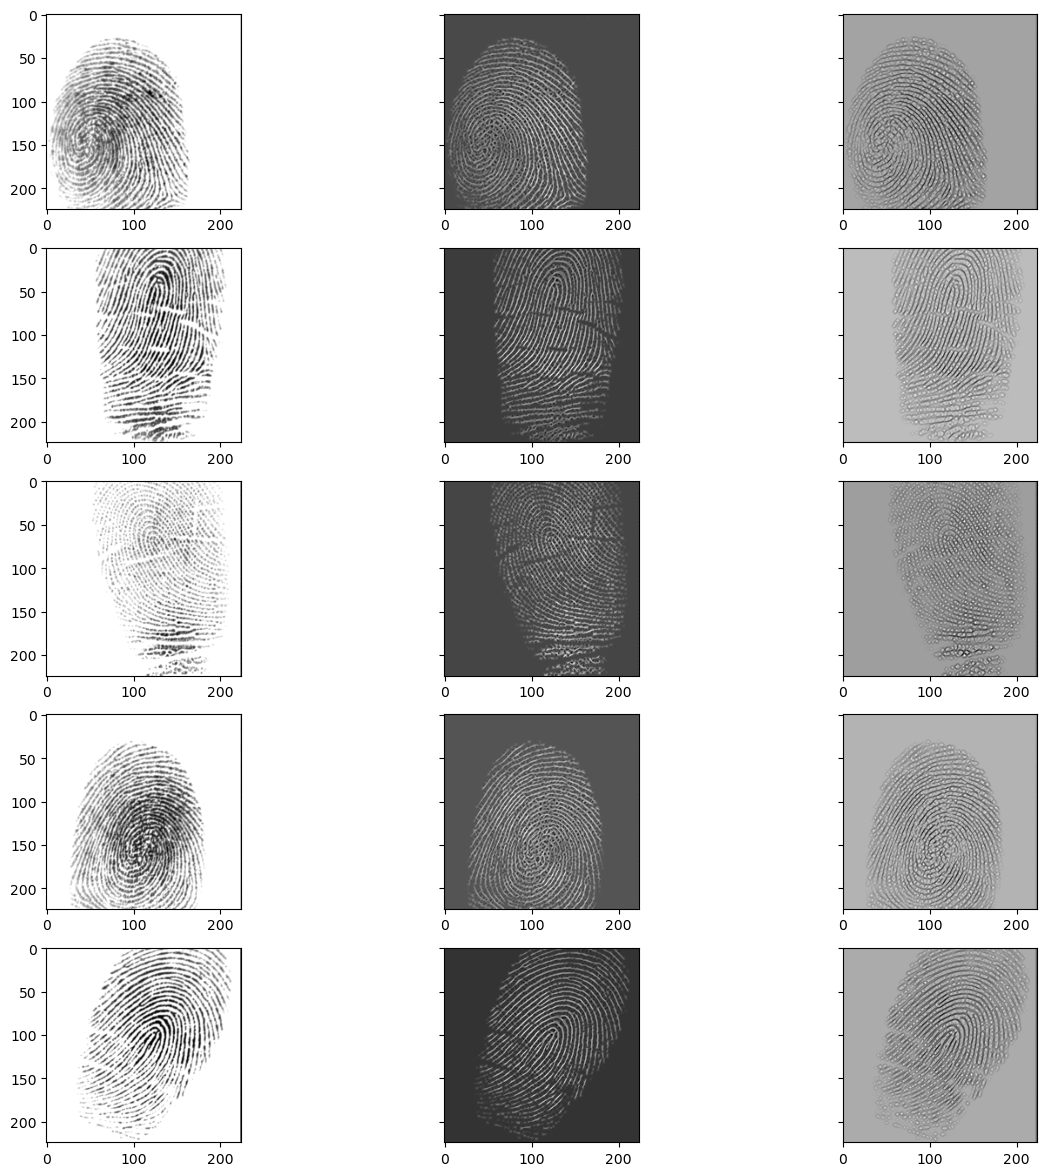

In [8]:
def detect_ridges(gray, sigma= 0.1):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges
fig, ax = plt.subplots(ncols=3, nrows = 5, sharey=True, figsize = (12,12))

for i, img in enumerate(images[:5]):
    a, b = detect_ridges(img,sigma=0.15)
    ax[i, 0].imshow(img, cmap='gray')
    ax[i, 1].imshow(a, cmap='gray')
    ax[i, 2].imshow(b, cmap='gray')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
plt.show()


In [9]:
def getTerminationBifurcation(img, mask):
    img = img == 255
    (rows, cols) = img.shape
    minutiaeTerm = np.zeros(img.shape)
    minutiaeBif = np.zeros(img.shape)
    
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            if(img[i][j] == 1):
                #generate a 3x3 block and check the values of its pixels
                block = img[i-1:i+2,j-1:j+2]
                block_val = np.sum(block)
                if(block_val == 2):
                    minutiaeTerm[i,j] = 1
                elif(block_val == 4):
                    minutiaeBif[i,j] = 1
    #https://scikit-image.org/docs/stable/auto_examples/edges/plot_convex_hull.html
    mask = convex_hull_image(mask>0)
    #similar to downsampling
    mask = erosion(mask, square(5))         
    #apply mask on minutiaeTerm
    minutiaeTerm = np.uint8(mask)*minutiaeTerm
    return(minutiaeTerm, minutiaeBif)

In [10]:
class MinutiaeFeature(object):
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX
        self.locY = locY
        self.Orientation = Orientation
        self.Type = Type

def computeAngle(block, minutiaeType):
    angle = 0
    (blkRows, blkCols) = np.shape(block)
    CenterX, CenterY = (blkRows-1)/2, (blkCols-1)/2
    if(minutiaeType.lower() == 'termination'):
        sumVal = 0
        for i in range(blkRows):
            for j in range(blkCols):
                #if pixel is at the box border and equals to 1
                if((i == 0 or i == blkRows-1 or j == 0 or j == blkCols-1) and block[i][j] != 0):
                    angle = -math.degrees(math.atan2(i-CenterY, j-CenterX))
                    sumVal += 1
                    #if more than 1 termination detected, return NaN
                    if(sumVal > 1):
                        angle = float('nan')
        return(angle)
    
    elif(minutiaeType.lower() == 'bifurcation'):
        (blkRows, blkCols) = np.shape(block)
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        angle = []
        sumVal = 0
        for i in range(blkRows):
            for j in range(blkCols):
                if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                    angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                    sumVal += 1
        #bifurcatiion should return 3
        if(sumVal != 3):
            angle = float('nan')
        return(angle)


def extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif):
    FeaturesTerm = []

    #Label connected regions of the minutiaTerm image with 2 hops.
    #https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label
    minutiaeTerm = skimage.measure.label(minutiaeTerm, connectivity=2)
    #stores all these termination in RP and highlights them
    RP = skimage.measure.regionprops(minutiaeTerm)
    
    WindowSize = 2          
    FeaturesTerm = []
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        #chooses a block from each termination detected
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        #compute all angles and appended to features of termination
        angle = computeAngle(block, 'Termination')
        FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

    FeaturesBif = []
    minutiaeBif = skimage.measure.label(minutiaeBif, connectivity=2);
    RP = skimage.measure.regionprops(minutiaeBif)
    WindowSize = 1 
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        angle = computeAngle(block, 'Bifurcation')
        FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
    return(FeaturesTerm, FeaturesBif)

def ShowResults(skel, TermLabel, BifLabel):
    minutiaeBif = TermLabel * 0
    minutiaeTerm = BifLabel * 0

    (rows, cols) = skel.shape
    DispImg = np.zeros((rows, cols, 3), np.uint8)
    DispImg[:, :, 0] = skel
    DispImg[:, :, 1] = skel
    DispImg[:, :, 2] = skel

    RP = skimage.measure.regionprops(BifLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeBif[row, col] = 1;
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 1)
        skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))

    RP = skimage.measure.regionprops(TermLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeTerm[row, col] = 1
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 1)
        skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255))
        
    plt.figure(figsize=(6,6))
    plt.title("Minutiae extraction results")
    plt.imshow(DispImg)

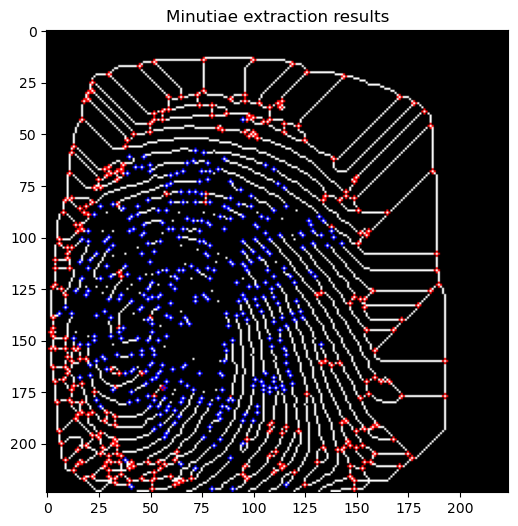

In [11]:
img = images[0]
img = np.array(img > img.mean()).astype(int)
skel = skimage.morphology.skeletonize(img)
skel = np.uint8(skel)*255
mask = img*255

(minutiaeTerm, minutiaeBif) = getTerminationBifurcation(skel, mask)
FeaturesTerm, FeaturesBif = extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif)
BifLabel = skimage.measure.label(minutiaeBif, connectivity=1)
TermLabel = skimage.measure.label(minutiaeTerm, connectivity=1)
ShowResults(skel, TermLabel, BifLabel)